<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/src/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Advanced MetPy: Quasi-Geostrophic Analysis</h1>
    <h3>AMS 2022 Short Course: MetPy for Quantitative Analysis of Meteorological Data</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Tasks
0. <a href="#import">Import required packages</a>
0. <a href="#narr">Access NARR Output</a>
0. <a href="#prep">Prepare data</a>
0. <a href="#terma">Compute Term A - Differential Vorticity Advection</a>
0. <a href="#termb">Compute Term B - Laplacian of Temperature Advection</a>
0. <a href="#4panel">Four Panel Plot</a>

This is a tutorial demonstrates common analyses for Synoptic Meteorology courses with use of Unidata tools, specifically [MetPy](https://unidata.github.io/MetPy/latest/) and [Siphon](https://unidata.github.io/siphon/latest/). In this tutorial we will cover accessing, calculating, and plotting model output.

### Background
Let's investigate [The Storm of the Century (1993)](https://en.wikipedia.org/wiki/1993_Storm_of_the_Century). This storm was massive, spanning most of North America's eastern seaboard. The eastern US and Canada received record snow accumulations (50"+ in the Blue Ridge Mountains and over 12" at Dulles and LaGuardia), ships in the Gulf of Mexico were sunk, and Florida saw several tornadoes and 10 foot storm surges. 

<img src="https://upload.wikimedia.org/wikipedia/commons/7/79/1993_storm_century.jpg"/>

The storm produced over $2 billion in damges. However, this event also was a turning point for operational forecasters who were able to identify this severe threat <b>five days</b> in advance. This was uprecedented lead time in 1993 and allowed for several states to call for a state of emergency even before snow started falling. 

This event shows us a textbook example of QG forcing. By examining reanalysis output, we can see very distinct regions of ascent and descent around the mature cyclone. However, please feel free to change the date used in this example to another event of your choice if desired.

### QG Omega Equation

Quasigeostrophic (QG) theory allows us to diagnose the processes leading to vertical air motion and the structural evolution of extratropical cyclones. Researchers and forecasters alike use the QG Omega equation to describe vertical air motion as it related to synoptic-scale vorticity growth and decay. In this lesson, we will calculate the primary forcing terms for ascent using reanalysis output and MetPy analysis functions.  

Here is the QG Omega equation from Bluestein (1992; Eq. 5.6.11) with the two primary forcing terms on the right hand side of this equation. [More info](http://www.atmos.albany.edu/daes/atmclasses/atm401/PPTs-PDFs_files/qgomega-usersguide.pdf)

$$\left(\nabla_p ^2 + \frac{f^2}{\sigma}\frac{\partial ^2}{\partial p^2}\right)\omega = 
-\frac{f_o}{\sigma}\frac{\partial}{\partial p}\left[-\vec{V_g} \cdot \nabla_p \left(\zeta_g + f \right)\right]
-\frac{R}{\sigma p} \nabla_p ^2 \left[-\vec{V_g} \cdot \nabla_p T \right]$$

The first term on the right hand side, which we will call **Term A** describes **differential vorticity advection**. 

The second term on the right hand side, which we will call **Term B**, describes the **lapacian of temperature advection**. 

#### Goal
Calculate Term A and Term B at 700 hPa. 


<div class="alert alert-success">
    <b>EXERCISE</b>:
    Examine requirements
<ol>
    <li>Given the QG Omega equation above, what variables do we need from our data source? <a href="https://www.ncei.noaa.gov/products/weather-climate-models/north-american-regional" target="blank">North American Regional Reanalysis (NARR)</a></li>
    <li>Which <a href="https://unidata.github.io/MetPy/latest/api/generated/metpy.constants.html" target="blank">constants</a> are available in MetPy?</li>
    </ol>
</div>

In [1]:
# COMMENT YOUR RESPONSES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
    <ol>
    <li>Geopotential height (to calculate geostrophic wind) and temperature</li>
    <li>Dry gas constant, Rd</li>
    </ol>
</div>

<a name="import"></a>
### Step 0: Import required packages

In [2]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy.constants as mpconstants
import numpy as np
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import xarray as xr

from metpy.units import units

<a name="narr"></a>
### Step 1: Access NARR Output
NARR output is made available on a THREDDS Data Server (TDS) hosted by NCEI. 

https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/north-american-regional-reanalysis-narr

We can use an NCSS query to access the remote data for our chosen storm. If you choose to use the 1993 Storm of the Century, that date will be March 13, 1993 at 1200Z

In [3]:
# Case Study Date
year = 1993
month = 3
day = 13
hour = 12

dt = datetime(year, month, day, hour)

Next, we set up access to request subsets of data from the model. This uses the OPENDaP protocol to make requests from the GRIB collection and get results in netCDF format.

In [4]:
# Read NARR Data from THREDDS server
base_url = 'https://www.ncei.noaa.gov/thredds/catalog/model-narr-a-files/'

# Programmatically generate the URL to the day of data we want
cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')

# Have Siphon find the appropriate dataset
tds_ds = cat.datasets.filter_time_nearest(dt)

# Interface with the data through the NetCDF Subset Service (NCSS) 
ncss = tds_ds.subset()

NARR output contains [many variables](https://www.ncei.noaa.gov/thredds/ncss/model-narr-a-files/199303/19930313/narr-a_221_19930313_1200_000.grb/dataset.html). In fact, too many to search for all the variables we need for this analysis. Instead of printing `ncss.variables` and listing all 100+ variable names, we can ask Python to only display variables that end with "isobaric". This suffix is how the TDS denotes GRIB fields that are specified on isobaric levels.

In [5]:
# Print the available variable names on isobaric surfaces
sorted(v for v in ncss.variables if v.endswith('isobaric'))

['Cloud_water_isobaric',
 'Geopotential_height_isobaric',
 'Horizontal_moisture_divergence_isobaric',
 'Ice_mixing_ratio_isobaric',
 'Pressure_Vertical_velocity_isobaric',
 'Specific_humidity_isobaric',
 'Temperature_isobaric',
 'Turbulent_Kinetic_Energy_isobaric',
 'u-component_of_wind_isobaric',
 'v-component_of_wind_isobaric']

<div class="alert alert-success">
    <b>EXERCISE</b>: Complete the NCSS query
    
    
Complete the NCSS query for the required geopotential height and temperature variables needed for our calculations.
</div>

In [6]:
# Create an NCSS query with our desired specifications
query = ncss.query()
query.lonlat_box(north=60, south=18, east=300, west=225)
query.time(dt)
query.add_lonlat()
query.accept('netcdf')

# TO DO: Select variables
query.variables()

# Use the query to obtain our NetCDF data
data = ncss.get_data(query)

HTTPError: Error accessing https://www.ncei.noaa.gov/thredds/ncss/model-narr-a-files/199303/19930313/narr-a_221_19930313_1200_000.grb?time=1993-03-13T12%3A00%3A00&west=225&east=300&south=18&north=60&addLatLon=True&accept=netcdf
Server Error (400: Validation errors: No variables requested  -- )

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [7]:
# Create an NCSS query with our desired specifications
query = ncss.query()
query.lonlat_box(north=60, south=18, east=300, west=225)
query.time(dt)
query.accept('netcdf')
query.variables('Geopotential_height_isobaric',
                'Temperature_isobaric')

# Use the query to obtain our NetCDF data
data = ncss.get_data(query)

Next, open the data with xarray and parse it with MetPy for CF conventions, also assigning lat/lon values

In [8]:
# Open data with xarray, and parse it with MetPy
ds = xr.open_dataset(xr.backends.NetCDF4DataStore(data)).metpy.parse_cf()

# Use MetPy to add latitude and longitude coordinates
ds = ds.metpy.assign_latitude_longitude()

<a name="prep"></a>
### Step 2: Prepare data
Since we are calculating QG omega at **700 hPa**, subset just the geopotential height and temperature at the 700 hPa level into an xarray DataArray. We can easily do this using xarray's `.sel()` method. We can also leverage MetPy's units inside the selection to ensure we are selecting the correct level. 

In [9]:
# This is the time we're using
vtime = ds['Temperature_isobaric'].metpy.time[0]

# Grabbing data for specific variable contained in file (as a unit array)
# 700 hPa Geopotential Heights
hght_700 = ds['Geopotential_height_isobaric'].metpy.sel(vertical = 700 * units.hPa, time=vtime)

# 700 hPa Temperature
tmpk_700 = ds['Temperature_isobaric'].metpy.sel(vertical = 700 * units.hPa, time=vtime)

<div class="alert alert-success">
    <b>EXERCISE</b>: Calculate geopotential heights at 500 and 900 hPa
    
Since the QG Omega equation includes calculating a differential, we will also need the geopotential heights for levels above and below 700 hPa. In this exercise, create two more DataArrays of geopotential height at 500 and 900 hPa.
    
Calculate:
     <ul>
         <li>hght_500: 500-hPa Geopotential_height_isobaric</li>
         <li>hght_900: 900-hPa Geopotential_height_isobaric</li>
    </ul>
</div>

In [10]:
# YOUR CODE GOES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [11]:
# Solution
# 500 hPa Geopotential Height
hght_500 = ds['Geopotential_height_isobaric'].metpy.sel(vertical = 500 * units.hPa, time=vtime)

# 900 hPa Geopotential Height
hght_900 = ds['Geopotential_height_isobaric'].metpy.sel(vertical = 900 * units.hPa, time=vtime)

Next we define the constants we need for the calculations.

In [12]:
# Set constant values that will be needed in computations

# Set default static stability value
sigma = 2.0e-6 * units('m^2 Pa^-2 s^-2')

# Set f-plane at typical synoptic f0 value
f0 = 1e-4 * units('s^-1')

# Use dry gas constant from MetPy constants
Rd = mpconstants.Rd

For calculation purposes we want to smooth our variables a little to get to the "synoptic values" from the higher resolution dataset we are using

In [13]:
# Smooth Heights

# Number of repetitions of smoothing function
n_reps = 50

# Apply the 9-point smoother
hght_700s = mpcalc.smooth_n_point(hght_700, 9, n_reps)
hght_500s = mpcalc.smooth_n_point(hght_500, 9, n_reps)
hght_900s = mpcalc.smooth_n_point(hght_900, 9, n_reps)

tmpk_700s = mpcalc.smooth_n_point(tmpk_700, 9, n_reps)
tmpc_700s = tmpk_700s.metpy.convert_units('degC')

<div class="alert alert-success">
    <b>EXERCISE</b>: Calculate u and v geostrophic wind
    
We can calculate the u and v components of the geostrophic wind from geopotential heights using a MetPy function.
    
Task: <br>
    Locate the appropriate geostrophic wind function in the <a href="https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html" target="blank">MetPy documentation</a> and calculate the following variables. 
    
Variables:
     <ul>
         <li>ug_900s, vg_900s: 900-hPa Geostrophic Wind</li>
         <li>ug_700s, vg_700s: 700-hPa Geostrophic Wind</li>
         <li>ug_500s, vg_500s: 500-hPa Geostrophic Wind</li>
    </ul>
    
Hint: <br>
    Ignore any optional inputs in this calculation
</div>

In [14]:
# YOUR CODE GOES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [15]:
# Calculate the geostrophic wind using the MetPy function
# mpcalc.geostrophic_wind
# 900-hPa Geostrophic Wind
ug_900s, vg_900s = mpcalc.geostrophic_wind(hght_900s)

# 700-hPa Geostrophic Wind
ug_700s, vg_700s = mpcalc.geostrophic_wind(hght_700s)

# 500-hPa Geostrophic Wind
ug_500s, vg_500s = mpcalc.geostrophic_wind(hght_500s)

<a name="terma"></a>
### Step 3: Compute Term A - Differential Vorticity Advection

$$-\frac{f_o}{\sigma}\frac{\partial}{\partial p}\left[-\vec{V_g} \cdot \nabla_p \left(\zeta_g + f \right)\right]$$


We will approach this calculation from the inside out in this order: 
1. absolute vorticity at two levels (e.g., 500 and 900 hPa) $$\left(\zeta_g + f \right)$$
2. absolute vorticity advection at same two levels $$\left[-\vec{V_g} \cdot \nabla_p \left(\zeta_g + f \right)\right]$$
3. centered finite-difference between two levels (e.g., valid at 700 hPa )$$\frac{\partial}{\partial p}\left[-\vec{V_g} \cdot \nabla_p \left(\zeta_g + f \right)\right]$$
4. apply constants to calculate value of full term $$-\frac{f_o}{\sigma}\frac{\partial}{\partial p}\left[-\vec{V_g} \cdot \nabla_p \left(\zeta_g + f \right)\right]$$

**NOTE:** By definition, the advection term in MetPy is calculated as (using temperature advection as an example) is:

$$-\vec{V} \cdot \nabla_p T$$

In [16]:
# Absolute Vorticity Calculation
avor_900 = mpcalc.absolute_vorticity(ug_900s, vg_900s)
avor_500 = mpcalc.absolute_vorticity(ug_500s, vg_500s)

# Absolute Vorticity Advection
vortadv_900 = mpcalc.advection(avor_900, ug_900s, vg_900s)
vortadv_500 = mpcalc.advection(avor_500, ug_500s, vg_500s)

# Differential (centered finite-difference) Vorticity Advection between two levels
diff_avor = ((vortadv_900 - vortadv_500)/(400 * units.hPa).to_base_units())

# Apply constants to final differential vorticity advection term
term_A = -(f0 / sigma.to_base_units() * diff_avor)

# Examine the units of Term A
term_A.metpy.units

/Users/dcamron/mambaforge/envs/pyaos-ams-2022/lib/python3.10/site-packages/metpy/xarray.py:1471: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(


<Unit('kilogram / meter ** 3 / second ** 3')>

<a name="termb"></a>
### Step 4: Compute Term B - Laplacian of Temperature Advection

$$-\frac{R}{\sigma p} \nabla_p ^2 \left[-\vec{V_g} \cdot \nabla_p T \right]$$

<div class="alert alert-success">
    <b>EXERCISE</b>: Compute Term B

Compute Term B using the same inside out method as previous
    
Tasks:
    
 <ol>
     <li>Temperature advection at 700 hPa (tadv_700) $$\left[-\vec{V_g} \cdot \nabla_p T \right]$$</li> 
     <li>Laplacian of Temp Adv. at 700 hPa (lap_tadv_700) $$\nabla_p ^2 \left[-\vec{V_g} \cdot \nabla_p T \right]$$</li>
     <li>Final term B with appropriate constants (term_B) $$-\frac{R}{\sigma p} \nabla_p ^2 \left[-\vec{V_g} \cdot \nabla_p T \right]$$</li>
     <li>Compare the output units of Term B with that of Term A</li>
</ol>
    
For information on how to calculate a Laplacian using MetPy, see the <a href="https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.laplacian.html">documentation</a> on this function.
</div>

In [17]:
# YOUR CODE GOES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [18]:
# Solution
# Temperature Advection
tadv_700 = mpcalc.advection(tmpc_700s, ug_700s, vg_700s)

# Laplacian of Temperature Advection
lap_tadv_700 = mpcalc.laplacian(tadv_700)

# Calculation of final Laplacian of Temperature Advection term
term_B = -(Rd / (sigma * (700 * units.hPa)) * lap_tadv_700).metpy.convert_units(term_A.data.units)

term_B.metpy.units

/Users/dcamron/mambaforge/envs/pyaos-ams-2022/lib/python3.10/site-packages/metpy/xarray.py:1471: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(


<Unit('kilogram / meter ** 3 / second ** 3')>

<a name="4panel"></a>
### Step 5: Plot

Upper-left Panel: 700-hPa Geopotential Heights, Temperature, and Winds

Upper-right Panel: 500-hPa Geopotential Heights, Absolute Vorticity, and Winds

Lower-left Panel: Term B (Laplacian of Temperature Advection)

Lower-right Panel: Term A (Laplacian of differential Vorticity Advection)

In [19]:
# Set some contour intervals for various parameters

# CINT 500 hPa Heights
clev_hght_500 = np.arange(0, 7000, 60)
# CINT 700 hPa Heights
clev_hght_700 = np.arange(0, 7000, 30)
# CINT 700 hPa Temps
clev_tmpc_700 = np.arange(-40, 41, 5)
# CINT Omega terms
clev_omega = np.arange(-5, 5.1, .5)

In [20]:
# Set some projections for our data (from NARR data)
# and output maps (Lambert Conformal)

# Data projection; NARR Data
dataproj = ds.Geopotential_height_isobaric.metpy.cartopy_crs

# Plot projection
# The look you want for the view, LambertConformal for mid-latitude view
plotproj = ccrs.LambertConformal(central_longitude=-100.,
                                 central_latitude=40.,
                                 standard_parallels=[30, 60])

# Set plotting variables
x = ds.x
y = ds.y
xx, yy = np.meshgrid(x, y)

#### Start 4-panel Figure

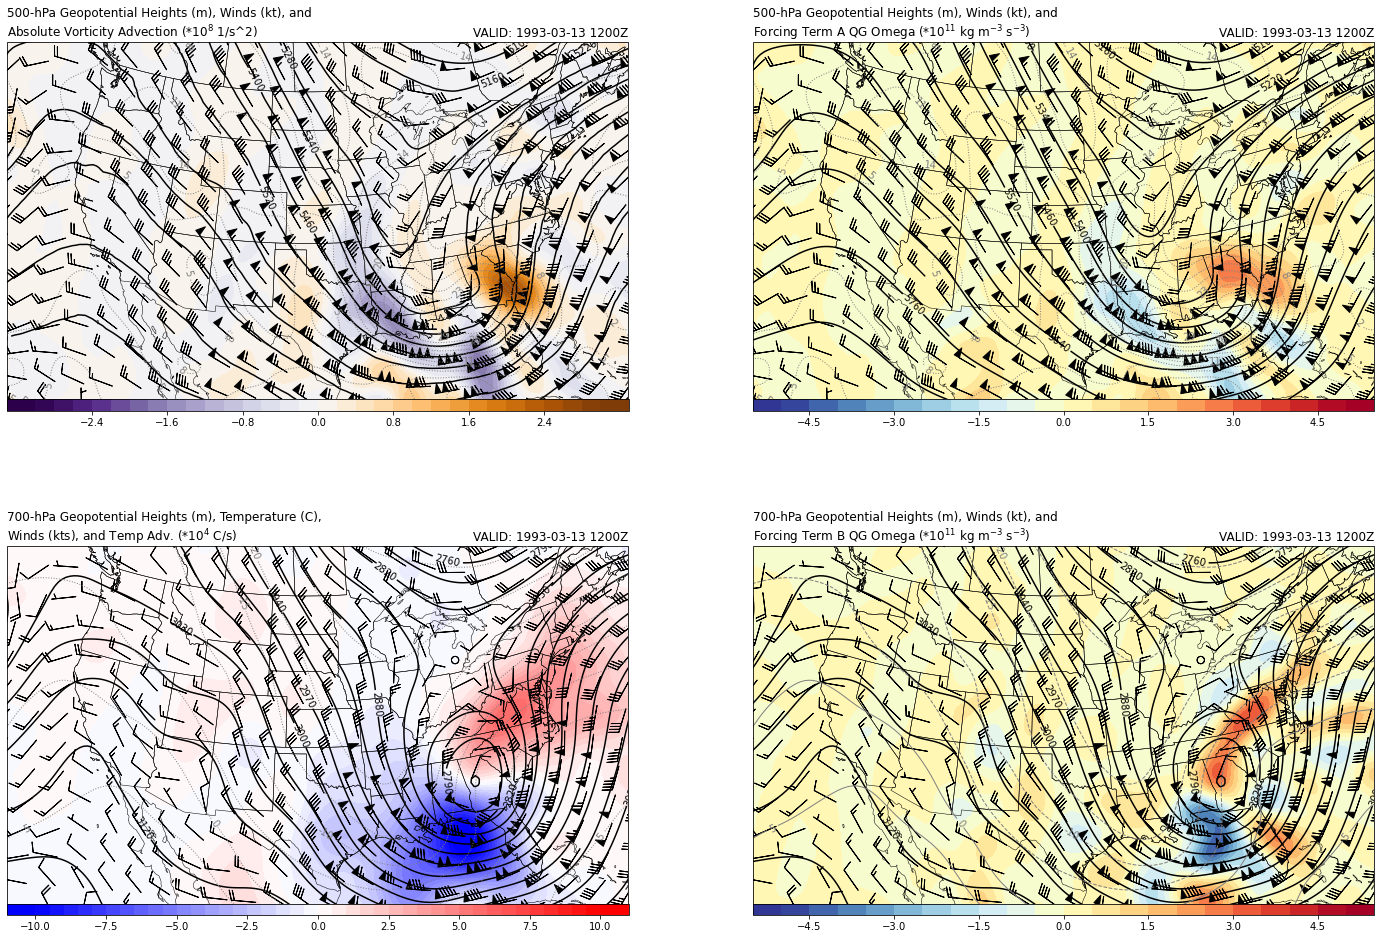

In [21]:
# Set a skip variable to limit number of barbs plotted
barb_skip = (slice(None, None, 8), slice(None, None, 8))

# Format the valid time
vtime_str = str(vtime.dt.strftime('%Y-%m-%d %H%MZ').values)

# Set figure size
fig=plt.figure(1, figsize=(24.5,17.))

################################################################################
# Upper-Left Panel
ax=plt.subplot(221, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour #1
clev500 = np.arange(0,7000,60)
cs = ax.contour(x, y, hght_500, clev500, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(x, y, avor_500*10**5, np.arange(-40, 41, 3),colors='grey',
                linewidths=1.0, linestyles='dotted', transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d',
           rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(x, y, vortadv_500*10**8, np.arange(-3, 3.1, 0.2),
                 cmap=plt.cm.PuOr_r, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True)

# Vector
ax.barbs(xx[barb_skip], yy[barb_skip],
         ug_500s.metpy.convert_units('kt').values[barb_skip],
         vg_500s.metpy.convert_units('kt').values[barb_skip],
         transform=dataproj)

# Titles
plt.title('500-hPa Geopotential Heights (m), Winds (kt), and\n'
          'Absolute Vorticity Advection ($*10^{8}$ 1/s^2)',loc='left')
plt.title(f'VALID: {vtime_str}', loc='right')
################################################################################

################################################################################
# Upper-Right Panel
ax=plt.subplot(222, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour #1
cs = ax.contour(x, y, hght_500s, clev500, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(x, y, avor_500*10**5, np.arange(-40, 41, 3), colors='grey',
                linewidths=1.0, linestyles='dotted', transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d',
           rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(x, y, term_A*10**11, clev_omega,
                 cmap=plt.cm.RdYlBu_r, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True)

# Vector
ax.barbs(xx[barb_skip], yy[barb_skip],
         ug_500s.metpy.convert_units('kt').values[barb_skip],
         vg_500s.metpy.convert_units('kt').values[barb_skip],
         transform=dataproj)

# Titles
plt.title('500-hPa Geopotential Heights (m), Winds (kt), and\n'
          'Forcing Term A QG Omega ($*10^{11}$ kg m$^{-3}$ s$^{-3}$)',loc='left')
plt.title(f'VALID: {vtime_str}', loc='right')
################################################################################

################################################################################
# Lower-Left Panel
ax=plt.subplot(223, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour #1
cs = ax.contour(x, y, hght_700s, clev_hght_700, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(x, y, tmpc_700s, clev_tmpc_700, colors='grey',
                linewidths=1.0, linestyles='dotted', transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d',
           rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(x, y, tadv_700*10**4, np.arange(-10, 10.1, 0.5),
                 cmap=plt.cm.bwr, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True)

# Vector
ax.barbs(xx[barb_skip], yy[barb_skip],
         ug_700s.metpy.convert_units('kt').values[barb_skip],
         vg_700s.metpy.convert_units('kt').values[barb_skip],
         transform=dataproj)

# Titles
plt.title('700-hPa Geopotential Heights (m), Temperature (C),\n'
          'Winds (kts), and Temp Adv. ($*10^4$ C/s)',loc='left')
plt.title(f'VALID: {vtime_str}', loc='right')
################################################################################

################################################################################
# Lower-Right Panel
ax=plt.subplot(224, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour #1
cs = ax.contour(x, y, hght_700s, clev_hght_700, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(x, y, tmpc_700s, clev_tmpc_700, colors='grey',
                linewidths=1.0, transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d',
           rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(x, y, term_B*10**11, clev_omega,
                 cmap=plt.cm.RdYlBu_r, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True)

# Vector
ax.barbs(xx[barb_skip], yy[barb_skip],
         ug_700s.metpy.convert_units('kt').values[barb_skip],
         vg_700s.metpy.convert_units('kt').values[barb_skip],
         transform=dataproj)

# Titles
plt.title('700-hPa Geopotential Heights (m), Winds (kt), and\n'
          'Forcing Term B QG Omega ($*10^{11}$ kg m$^{-3}$ s$^{-3}$)',loc='left')
plt.title(f'VALID: {vtime_str}', loc='right')
################################################################################

plt.show()

<div class="alert alert-success">
    <b>[OPTIONAL] EXERCISE</b>:
     <ul>
         <li>Plot the combined QG Omega forcing terms (term_A + term_B) in a single panel.</li>
         <li><b>BONUS:</b> Compute a difference map of Term A and Term B and plot.</li>
    </ul>
</div>

In [22]:
# YOUR CODE GOES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

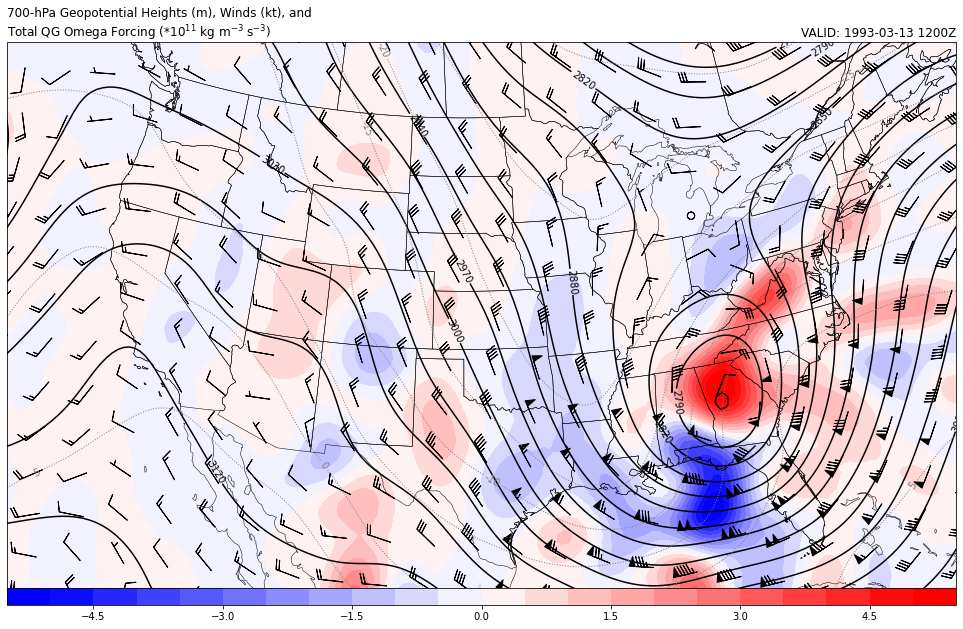

In [23]:
# Solution

# Set a skip variable to limit number of barbs plotted
barb_skip = (slice(None, None, 8), slice(None, None, 8))

# Format the valid time
vtime_str = str(vtime.dt.strftime('%Y-%m-%d %H%MZ').values)

# Set figure size
fig=plt.figure(1, figsize=(17.,12.))

ax=plt.subplot(111, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour #1
cs = ax.contour(x, y, hght_700s, clev_hght_700, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(x, y, tmpc_700s, clev_tmpc_700, colors='grey',
                linewidths=1.0, linestyles='dotted', transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d',
           rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(x, y, (term_A+term_B)*10**11, clev_omega,
                 cmap=plt.cm.bwr, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True)

# Vector
ax.barbs(xx[barb_skip], yy[barb_skip],
         ug_700s.metpy.convert_units('kt').values[barb_skip],
         vg_700s.metpy.convert_units('kt').values[barb_skip],
         transform=dataproj)

# Titles
plt.title('700-hPa Geopotential Heights (m), Winds (kt), and\n'
          'Total QG Omega Forcing ($*10^{11}$ kg m$^{-3}$ s$^{-3}$)',loc='left')
plt.title(f'VALID: {vtime_str}', loc='right')

plt.show()

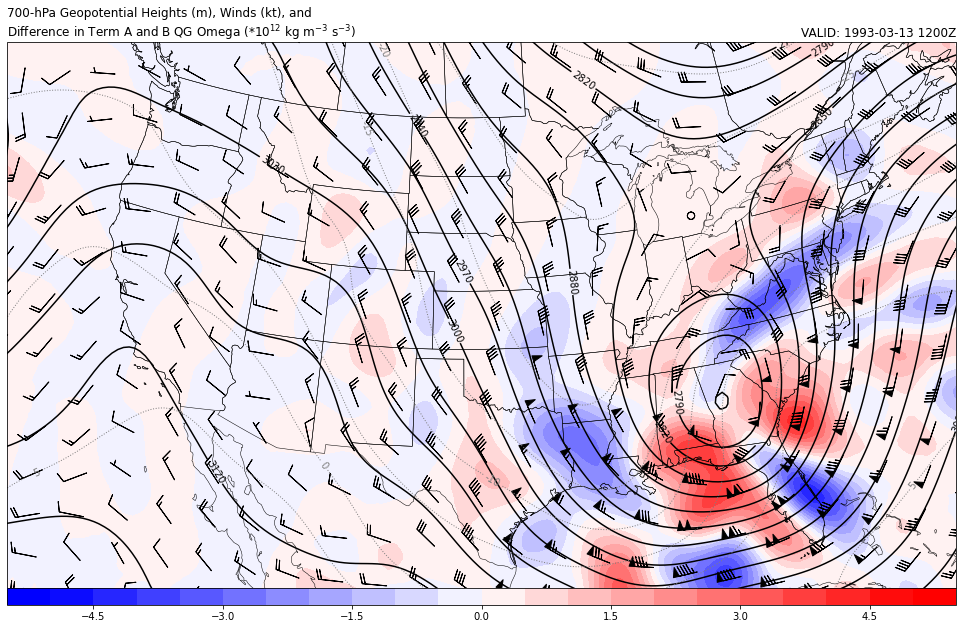

In [24]:
# BONUS Solution

# Set a skip variable to limit number of barbs plotted
barb_skip = (slice(None, None, 8), slice(None, None, 8))

# Format the valid time
vtime_str = str(vtime.dt.strftime('%Y-%m-%d %H%MZ').values)

# Set figure size
fig=plt.figure(1, figsize=(17.,12.))

ax=plt.subplot(111, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour #1
cs = ax.contour(x, y, hght_700s, clev_hght_700, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(x, y, tmpc_700s, clev_tmpc_700, colors='grey',
                linewidths=1.0, linestyles='dotted', transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d',
           rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(x, y, (term_A-term_B)*10**11, clev_omega,
                 cmap=plt.cm.bwr, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True)

# Vector
ax.barbs(xx[barb_skip], yy[barb_skip],
         ug_700s.metpy.convert_units('kt').values[barb_skip],
         vg_700s.metpy.convert_units('kt').values[barb_skip],
         transform=dataproj)

# Titles
plt.title('700-hPa Geopotential Heights (m), Winds (kt), and\n'
          'Difference in Term A and B QG Omega ($*10^{12}$ kg m$^{-3}$ s$^{-3}$)',loc='left')
plt.title(f'VALID: {vtime_str}', loc='right')

plt.show()